# Efficient Deep Learning — Lab Knowledge Distillation (CIFAR-10)
**Teacher:** ResNet50 (ImageNet-pretrained)  
**Student:** ResNet18 (ImageNet-pretrained)  
This notebook covers steps 1–4 of Strategy 1: baseline training + KD on logits.



Objectif : étudier la distillation de connaissances entre un teacher (ResNet50)
et un student (ResNet18) sur CIFAR-10, avec et sans pré-entraînement.


In [32]:
# Imports & setup Python
from __future__ import annotations

import os
import random
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from tqdm.auto import tqdm



In [33]:
# ===== Drive + Audit =====
from google.colab import drive
drive.mount('/content/drive')

import os, glob
CKPT_DIR = "/content/drive/MyDrive/KD_checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

print("✅ CKPT_DIR =", CKPT_DIR)

expected = [
    "teacher_resnet50_best.pt",
    "student_pretrained_baseline_best.pt",
    "student_pretrained_kd_logits_best.pt",
    "student_pretrained_kd_features_best.pt",
    "student_scratch_baseline_best.pt",
    "student_scratch_kd_scores_best.pt",
]

present = set(os.path.basename(x) for x in glob.glob(CKPT_DIR+"/*.pt")) | \
          set(os.path.basename(x) for x in glob.glob(CKPT_DIR+"/*.pth"))

print("\n✅ PRESENT:")
for f in expected:
    if f in present:
        print(" -", f)

print("\n❌ MISSING:")
for f in expected:
    if f not in present:
        print(" -", f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ CKPT_DIR = /content/drive/MyDrive/KD_checkpoints

✅ PRESENT:
 - teacher_resnet50_best.pt
 - student_pretrained_baseline_best.pt
 - student_pretrained_kd_logits_best.pt
 - student_pretrained_kd_features_best.pt
 - student_scratch_baseline_best.pt
 - student_scratch_kd_scores_best.pt

❌ MISSING:


In [34]:
# Reproductibilité + device
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [35]:
# Configuration centrale
@dataclass
class CFG:
    data_root: str = "./data"
    num_classes: int = 10
    img_size: int = 224
    batch_size: int = 128
    num_workers: int = 0
    lr: float = 1e-3
    weight_decay: float = 1e-4
    epochs_teacher: int = 10
    epochs_student: int = 10
    epochs_kd: int = 10
    val_ratio: float = 0.1

cfg = CFG()
cfg

CFG(data_root='./data', num_classes=10, img_size=224, batch_size=128, num_workers=0, lr=0.001, weight_decay=0.0001, epochs_teacher=10, epochs_student=10, epochs_kd=10, val_ratio=0.1)

## Dataset & Data Split
- Dataset : CIFAR-10
- Train / Validation / Test
- Même split utilisé pour tous les modèles



In [36]:
# Transforms (CIFAR10 -> ImageNet style)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize(cfg.img_size),
    transforms.RandomCrop(cfg.img_size, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tfms = transforms.Compose([
    transforms.Resize(cfg.img_size),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])



In [37]:
# Dataset & Dataloaders SANS multiprocessing

full_train = datasets.CIFAR10(root=cfg.data_root, train=True, download=True, transform=train_tfms)
full_test  = datasets.CIFAR10(root=cfg.data_root, train=False, download=True, transform=test_tfms)

n_total = len(full_train)
n_val = int(cfg.val_ratio * n_total)
n_train = n_total - n_val

train_ds, val_ds = random_split(
    full_train, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=0,      # <-- FIX
    pin_memory=False    # <-- FIX (utile surtout si CPU)
)
val_loader = DataLoader(
    val_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)
test_loader = DataLoader(
    full_test,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

len(train_ds), len(val_ds), len(full_test)


(45000, 5000, 10000)

In [38]:
# Utilitaires : nombre de paramètres
def count_trainable_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_total_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())



## Teacher Network (ResNet50)
- Pré-entraîné ImageNet
- Fine-tuning sur CIFAR-10
- Checkpoint chargé


In [39]:
# Build teacher & student
def build_resnet(model_name: str, num_classes: int, pretrained: bool = True) -> nn.Module:
    if model_name == "resnet50":
        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        model = models.resnet50(weights=weights)
    elif model_name == "resnet18":
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet18(weights=weights)
    else:
        raise ValueError("Unknown model")

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

teacher = build_resnet("resnet50", cfg.num_classes, pretrained=True).to(device)
student = build_resnet("resnet18", cfg.num_classes, pretrained=True).to(device)

print("Teacher params:", count_total_params(teacher))
print("Student params:", count_total_params(student))



Teacher params: 23528522
Student params: 11181642


In [40]:
# Boucles train / eval génériques
def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def train_one_epoch(model: nn.Module, loader: DataLoader, criterion, optimizer, device) -> Dict[str, float]:
    model.train()
    running_loss, running_acc = 0.0, 0.0

    for x, y in tqdm(loader, desc="train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc  += accuracy_from_logits(logits, y)

    return {"loss": running_loss / len(loader), "acc": running_acc / len(loader)}

@torch.no_grad()
def eval_one_epoch(model: nn.Module, loader: DataLoader, criterion, device) -> Dict[str, float]:
    model.eval()
    running_loss, running_acc = 0.0, 0.0

    for x, y in tqdm(loader, desc="eval", leave=False):
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item()
        running_acc  += accuracy_from_logits(logits, y)

    return {"loss": running_loss / len(loader), "acc": running_acc / len(loader)}



In [41]:
# Helper fit (baseline)
def fit(model: nn.Module, train_loader, val_loader, epochs: int, lr: float, wd: float,
        device, save_path: str) -> Dict[str, List[float]]:

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_acc = -1.0

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics   = eval_one_epoch(model, val_loader, criterion, device)

        history["train_loss"].append(train_metrics["loss"])
        history["train_acc"].append(train_metrics["acc"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])

        print(f"train loss={train_metrics['loss']:.4f} acc={train_metrics['acc']:.4f} | "
              f"val loss={val_metrics['loss']:.4f} acc={val_metrics['acc']:.4f}")

        if val_metrics["acc"] > best_val_acc:
            best_val_acc = val_metrics["acc"]
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model to {save_path}")

    return history



In [42]:
# Teacher (train OR load) =====
import os, torch

teacher_ckpt = f"{CKPT_DIR}/teacher_resnet50_best.pt"

if os.path.exists(teacher_ckpt):
    print(f"✅ Checkpoint trouvé, on CHARGE le teacher: {teacher_ckpt}")
    ckpt = torch.load(teacher_ckpt, map_location=device)
    teacher.load_state_dict(ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt)
    teacher_hist = None
else:
    print("❌ Pas de checkpoint teacher → entraînement…")
    teacher_hist = fit(
        teacher, train_loader, val_loader,
        epochs=cfg.epochs_teacher, lr=cfg.lr, wd=cfg.weight_decay,
        device=device, save_path=teacher_ckpt
    )
    print(f"✅ Teacher sauvegardé dans {teacher_ckpt}")


✅ Checkpoint trouvé, on CHARGE le teacher: /content/drive/MyDrive/KD_checkpoints/teacher_resnet50_best.pt


In [43]:
# Test Teacher
import torch
import torch.nn as nn

teacher_ckpt = f"{CKPT_DIR}/teacher_resnet50_best.pt"

ckpt = torch.load(teacher_ckpt, map_location=device)
teacher.load_state_dict(
    ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
)

teacher.eval()
teacher_test = eval_one_epoch(
    teacher, test_loader, nn.CrossEntropyLoss(), device
)
teacher_test


eval:   0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.22712226089420198, 'acc': 0.9296875}

In [44]:
# Student baseline (train OR load)
import os, torch

student_ckpt = f"{CKPT_DIR}/student_pretrained_baseline_best.pt"

if os.path.exists(student_ckpt):
    print(f"✅ Checkpoint trouvé, on CHARGE le student baseline: {student_ckpt}")
    ckpt = torch.load(student_ckpt, map_location=device)
    student.load_state_dict(ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt)
    student_hist = None
else:
    print("❌ Pas de checkpoint student baseline → entraînement…")
    student_hist = fit(
        student, train_loader, val_loader,
        epochs=cfg.epochs_student, lr=cfg.lr, wd=cfg.weight_decay,
        device=device, save_path=student_ckpt
    )
    print(f"✅ Student baseline sauvegardé dans {student_ckpt}")


✅ Checkpoint trouvé, on CHARGE le student baseline: /content/drive/MyDrive/KD_checkpoints/student_pretrained_baseline_best.pt


In [45]:
# Test Student Baseline
student_ckpt = f"{CKPT_DIR}/student_pretrained_baseline_best.pt"

ckpt = torch.load(student_ckpt, map_location=device)
student.load_state_dict(
    ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
)

student.eval()
student_test = eval_one_epoch(
    student, test_loader, nn.CrossEntropyLoss(), device
)
student_test


eval:   0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.2637814131530025, 'acc': 0.9212816455696202}

In [46]:
# Cellule 13 — KD loss (scores / logits)
#   KD_loss = α CE(student, labels) + (1-α) KL(student/T , teacher/T) * T²

class KDLoss(nn.Module):
    def __init__(self, temperature: float = 4.0, alpha: float = 0.5):
        super().__init__()
        self.T = temperature
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss()
        self.kl = nn.KLDivLoss(reduction="batchmean")

    def forward(self, student_logits, teacher_logits, targets):
        # Hard loss : student vs labels
        ce_loss = self.ce(student_logits, targets)

        # Soft loss : student vs teacher
        p_s = F.log_softmax(student_logits / self.T, dim=1)
        p_t = F.softmax(teacher_logits / self.T, dim=1)
        kd_loss = self.kl(p_s, p_t) * (self.T ** 2)

        # Combinaison
        return self.alpha * ce_loss + (1 - self.alpha) * kd_loss


In [47]:
# Knowledge Distillation (Scores Only)
import os
import torch
import torch.nn as nn

def freeze(model: nn.Module):
    for p in model.parameters():
        p.requires_grad = False
    model.eval()

freeze(teacher)

def fit_kd_scores(
    student: nn.Module,
    teacher: nn.Module,
    train_loader,
    val_loader,
    epochs: int,
    lr: float,
    wd: float,
    device,
    save_path: str,
    temperature: float = 4.0,
    alpha: float = 0.5
):
    kd_criterion = KDLoss(temperature=temperature, alpha=alpha)
    optimizer = torch.optim.AdamW(student.parameters(), lr=lr, weight_decay=wd)

    best_val_acc = -1.0

    for epoch in range(1, epochs + 1):
        student.train()
        tr_loss, tr_acc = 0.0, 0.0

        for x, y in tqdm(train_loader, desc=f"KD-Scores Ep {epoch}", leave=False):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.no_grad():
                t_logits = teacher(x)

            s_logits = student(x)
            loss = kd_criterion(s_logits, t_logits, y)

            loss.backward()
            optimizer.step()

            tr_loss += loss.item()
            tr_acc += accuracy_from_logits(s_logits, y)

        tr_loss /= len(train_loader)
        tr_acc /= len(train_loader)

        val_metrics = eval_one_epoch(student, val_loader, nn.CrossEntropyLoss(), device)

        print(
            f"\nEpoch {epoch}/{epochs} | "
            f"kd loss={tr_loss:.4f} acc={tr_acc:.4f} | "
            f"val acc={val_metrics['acc']:.4f}"
        )

        if val_metrics["acc"] > best_val_acc:
            best_val_acc = val_metrics["acc"]
            torch.save(student.state_dict(), save_path)
            print(f"✅ Saved best KD student to {save_path}")

# point d'entrée unique
print("\n--- Stratégie 1 : Student Pretrained KD (Scores) ---")

kd_scores_ckpt = f"{CKPT_DIR}/student_pretrained_kd_logits_best.pt"

if os.path.exists(kd_scores_ckpt):
    print(f"✅ Checkpoint KD logits trouvé → on charge: {kd_scores_ckpt}")
    ckpt = torch.load(kd_scores_ckpt, map_location=device)
    student.load_state_dict(
        ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
    )
else:
    print("❌ Pas de checkpoint KD logits → on entraîne…")
    fit_kd_scores(
        student, teacher, train_loader, val_loader,
        epochs=cfg.epochs_kd, lr=cfg.lr, wd=cfg.weight_decay,
        device=device, save_path=kd_scores_ckpt,
        temperature=4.0, alpha=0.5
    )



--- Stratégie 1 : Student Pretrained KD (Scores) ---
✅ Checkpoint KD logits trouvé → on charge: /content/drive/MyDrive/KD_checkpoints/student_pretrained_kd_logits_best.pt


In [48]:
# Test Student KD Scores
kd_scores_ckpt = f"{CKPT_DIR}/student_pretrained_kd_logits_best.pt"

ckpt = torch.load(kd_scores_ckpt, map_location=device)
student.load_state_dict(
    ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
)

student.eval()
student_kd_test = eval_one_epoch(
    student, test_loader, nn.CrossEntropyLoss(), device
)
student_kd_test


eval:   0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.22458757554428488, 'acc': 0.9311708860759493}

In [49]:
# Wrapper pour extraction features & Loss Mixte

class ResNetWithFeatures(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.backbone = original_model
        self.feat_map = None
        # Hook sur la dernière couche de convolution (layer4)
        self.backbone.layer4.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.feat_map = output

    def forward(self, x):
        logits = self.backbone(x)
        return logits, self.feat_map

# On wrap le teacher (déjà entraîné)
teacher_feat_model = ResNetWithFeatures(teacher)
teacher_feat_model.eval()

# Loss combinée : KD (Logits) + MSE (Features)
class KDFeatureLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.5, beta=100.0):
        super().__init__()
        self.kd_loss = KDLoss(temperature, alpha)
        self.mse = nn.MSELoss()
        self.beta = beta # Poids pour la distance entre features

    def forward(self, s_logits, t_logits, s_feat, t_feat, targets):
        loss_score = self.kd_loss(s_logits, t_logits, targets)
        loss_feat = self.mse(s_feat, t_feat)
        return loss_score + self.beta * loss_feat

print("✅ Wrapper Features & Loss définis.")

✅ Wrapper Features & Loss définis.


In [50]:
#KD Scores + Feature Maps (train OR load)
import os
import torch
import torch.nn as nn

def fit_kd_features(student_model, teacher_wrap, train_loader, val_loader,
                    epochs, lr, wd, device, save_path):

    student_wrap = ResNetWithFeatures(student_model).to(device)

    adapter = nn.Conv2d(512, 2048, kernel_size=1).to(device)

    optimizer = torch.optim.AdamW(
        list(student_wrap.parameters()) + list(adapter.parameters()),
        lr=lr, weight_decay=wd
    )

    criterion = KDFeatureLoss(temperature=4.0, alpha=0.5, beta=100.0)
    history = {"train_loss": [], "val_acc": []}
    best_acc = 0.0

    for epoch in range(1, epochs + 1):
        student_wrap.train()
        adapter.train()
        total_loss = 0.0

        for x, y in tqdm(train_loader, desc=f"KD-Feat Ep {epoch}", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)

            with torch.no_grad():
                t_logits, t_feat = teacher_wrap(x)

            s_logits, s_feat = student_wrap(x)
            s_feat_projected = adapter(s_feat)

            loss = criterion(s_logits, t_logits, s_feat_projected, t_feat, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_res = eval_one_epoch(
            student_wrap.backbone, val_loader, nn.CrossEntropyLoss(), device
        )

        history["train_loss"].append(total_loss / len(train_loader))
        history["val_acc"].append(val_res["acc"])

        print(f"Ep {epoch} | Loss={total_loss/len(train_loader):.4f} | Val Acc={val_res['acc']:.4f}")

        if val_res["acc"] > best_acc:
            best_acc = val_res["acc"]
            torch.save(student_wrap.backbone.state_dict(), save_path)
            print(f"✅ Saved best KD-Features student to {save_path}")

    return history


# point d'entrée unique
print("\n--- Stratégie 1 : KD Features + Scores ---")

kd_feat_ckpt = f"{CKPT_DIR}/student_pretrained_kd_features_best.pt"

# On reconstruit un student "propre" (pré-entraîné) dans les 2 cas
student_feat = build_resnet("resnet18", cfg.num_classes, pretrained=True).to(device)

if os.path.exists(kd_feat_ckpt):
    print(f"✅ Checkpoint KD features trouvé → on charge: {kd_feat_ckpt}")
    ckpt = torch.load(kd_feat_ckpt, map_location=device)
    state = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
    student_feat.load_state_dict(state)
    kd_feat_hist = None
else:
    print("❌ Pas de checkpoint KD features → on entraîne…")
    kd_feat_hist = fit_kd_features(
        student_feat, teacher_feat_model, train_loader, val_loader,
        epochs=cfg.epochs_kd, lr=cfg.lr, wd=cfg.weight_decay,
        device=device, save_path=kd_feat_ckpt
    )



--- Stratégie 1 : KD Features + Scores ---
✅ Checkpoint KD features trouvé → on charge: /content/drive/MyDrive/KD_checkpoints/student_pretrained_kd_features_best.pt



--- Stratégie 2 : Student Scratch Baseline ---
✅ Checkpoint scratch baseline trouvé → load: /content/drive/MyDrive/KD_checkpoints/student_scratch_baseline_best.pt

--- Stratégie 2 : Student Scratch KD (Scores) ---
✅ Checkpoint scratch KD scores trouvé → load: /content/drive/MyDrive/KD_checkpoints/student_scratch_kd_scores_best.pt


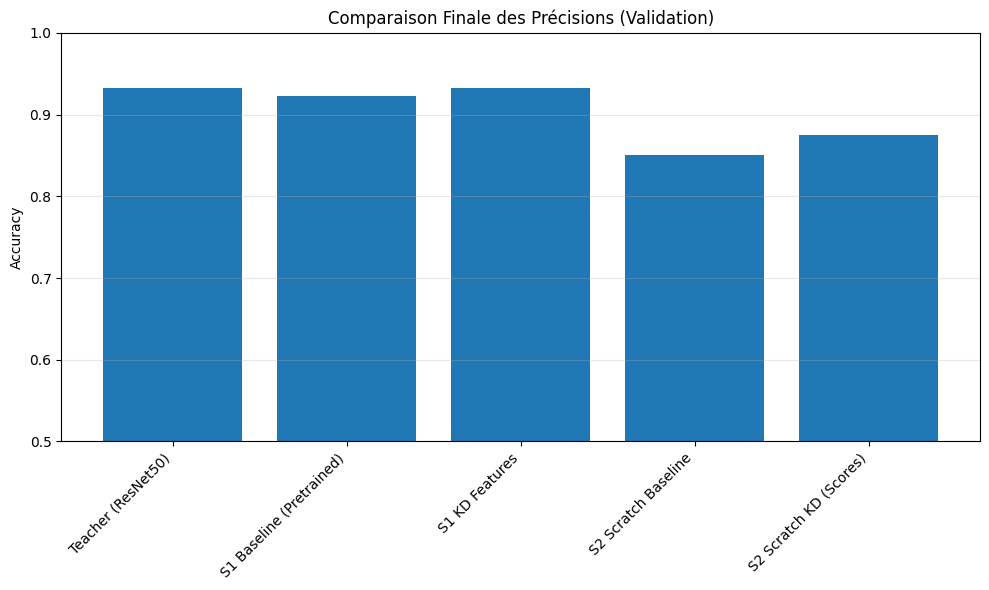

✅ TP Terminé : scratch + KD scratch sauvegardés sur Drive, comparaison affichée.


In [52]:
#Stratégie 2 : From Scratch + Visualisation Finale
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

assert "CKPT_DIR" in globals(), "❌ CKPT_DIR n'est pas défini. Exécute la cellule Drive d'abord."

def safe_load_state(model, path):
    ckpt = torch.load(path, map_location=device)
    state = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
    model.load_state_dict(state)
    return model

@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

# -------------------------
# 1) Scratch Baseline (train OR load)
# -------------------------
print("\n--- Stratégie 2 : Student Scratch Baseline ---")
scratch_ckpt = f"{CKPT_DIR}/student_scratch_baseline_best.pt"

student_scratch = build_resnet("resnet18", cfg.num_classes, pretrained=False).to(device)

if os.path.exists(scratch_ckpt):
    print(f"✅ Checkpoint scratch baseline trouvé → load: {scratch_ckpt}")
    safe_load_state(student_scratch, scratch_ckpt)
    scratch_hist = None
else:
    print("❌ Pas de checkpoint scratch baseline → entraînement…")
    scratch_hist = fit(
        student_scratch, train_loader, val_loader,
        epochs=cfg.epochs_student, lr=cfg.lr, wd=cfg.weight_decay,
        device=device, save_path=scratch_ckpt
    )
    print(f"✅ Scratch baseline sauvegardé → {scratch_ckpt}")

# -------------------------
# 2) Scratch KD Scores (train OR load)
# -------------------------
print("\n--- Stratégie 2 : Student Scratch KD (Scores) ---")
scratch_kd_ckpt = f"{CKPT_DIR}/student_scratch_kd_scores_best.pt"

student_scratch_kd = build_resnet("resnet18", cfg.num_classes, pretrained=False).to(device)

if os.path.exists(scratch_kd_ckpt):
    print(f"✅ Checkpoint scratch KD scores trouvé → load: {scratch_kd_ckpt}")
    safe_load_state(student_scratch_kd, scratch_kd_ckpt)
else:
    print("❌ Pas de checkpoint scratch KD scores → entraînement…")
    fit_kd_scores(
        student_scratch_kd, teacher, train_loader, val_loader,
        epochs=cfg.epochs_kd, lr=cfg.lr, wd=cfg.weight_decay,
        device=device, save_path=scratch_kd_ckpt,
        temperature=4.0, alpha=0.5
    )
    print(f"✅ Scratch KD scores sauvegardé → {scratch_kd_ckpt}")

# -------------------------
# VISUALISATION (robuste)
# -------------------------
scores = {}

# Teacher (history si dispo, sinon évalue un modèle chargé)
try:
    scores["Teacher (ResNet50)"] = max(teacher_hist["val_acc"])
except Exception:
    tpath = f"{CKPT_DIR}/teacher_resnet50_best.pt"
    if os.path.exists(tpath):
        ttmp = build_resnet("resnet50", cfg.num_classes, pretrained=True).to(device)
        safe_load_state(ttmp, tpath)
        scores["Teacher (ResNet50)"] = eval_acc(ttmp, val_loader)

# S1 Baseline pretrained
try:
    scores["S1 Baseline (Pretrained)"] = max(student_hist["val_acc"])
except Exception:
    spath = f"{CKPT_DIR}/student_pretrained_baseline_best.pt"
    if os.path.exists(spath):
        stmp = build_resnet("resnet18", cfg.num_classes, pretrained=True).to(device)
        safe_load_state(stmp, spath)
        scores["S1 Baseline (Pretrained)"] = eval_acc(stmp, val_loader)

# S1 KD Features (si tu l'as fait)
try:
    scores["S1 KD Features"] = max(kd_feat_hist["val_acc"])
except Exception:
    fpath = f"{CKPT_DIR}/student_pretrained_kd_features_best.pt"
    if os.path.exists(fpath):
        stmp = build_resnet("resnet18", cfg.num_classes, pretrained=True).to(device)
        safe_load_state(stmp, fpath)
        scores["S1 KD Features"] = eval_acc(stmp, val_loader)

# S2 Scratch baseline (history si dispo, sinon évalue le modèle chargé)
try:
    scores["S2 Scratch Baseline"] = max(scratch_hist["val_acc"])
except Exception:
    scores["S2 Scratch Baseline"] = eval_acc(student_scratch, val_loader)

# S2 Scratch KD scores (pas d'history -> eval direct)
scores["S2 Scratch KD (Scores)"] = eval_acc(student_scratch_kd, val_loader)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(list(scores.keys()), list(scores.values()))
plt.title("Comparaison Finale des Précisions (Validation)")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(f"{CKPT_DIR}/comparaison_finale.png")
plt.show()

print("✅ TP Terminé : scratch + KD scratch sauvegardés sur Drive, comparaison affichée.")


In [53]:
import os
import torch
import matplotlib.pyplot as plt

# 1) Si on a l'historique -> on plot
if ("teacher_hist" in globals()) and (teacher_hist is not None) and ("train_acc" in teacher_hist):
    epochs = range(1, len(teacher_hist["train_acc"]) + 1)

    plt.figure()
    plt.plot(epochs, teacher_hist["train_acc"], label="Teacher train")
    plt.plot(epochs, teacher_hist["val_acc"], label="Teacher val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Teacher accuracy")
    plt.show()

# 2) Sinon -> on calcule juste l'accuracy (pas de courbe)
else:
    print("⚠️ teacher_hist est None (checkpoint chargé, pas d'historique).")
    print("👉 Je calcule juste l'accuracy du teacher sur val/test.")

    teacher_ckpt = f"{CKPT_DIR}/teacher_resnet50_best.pt"
    assert os.path.exists(teacher_ckpt), f"Checkpoint introuvable: {teacher_ckpt}"

    ckpt = torch.load(teacher_ckpt, map_location=device)
    teacher.load_state_dict(ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt)
    teacher.eval()

    teacher_val = eval_one_epoch(teacher, val_loader, torch.nn.CrossEntropyLoss(), device)
    teacher_test = eval_one_epoch(teacher, test_loader, torch.nn.CrossEntropyLoss(), device)

    print("✅ Teacher val:", teacher_val)
    print("✅ Teacher test:", teacher_test)


⚠️ teacher_hist est None (checkpoint chargé, pas d'historique).
👉 Je calcule juste l'accuracy du teacher sur val/test.


eval:   0%|          | 0/40 [00:00<?, ?it/s]

eval:   0%|          | 0/79 [00:00<?, ?it/s]

✅ Teacher val: {'loss': 0.21044016634114088, 'acc': 0.932421875}
✅ Teacher test: {'loss': 0.22712226089420198, 'acc': 0.9296875}


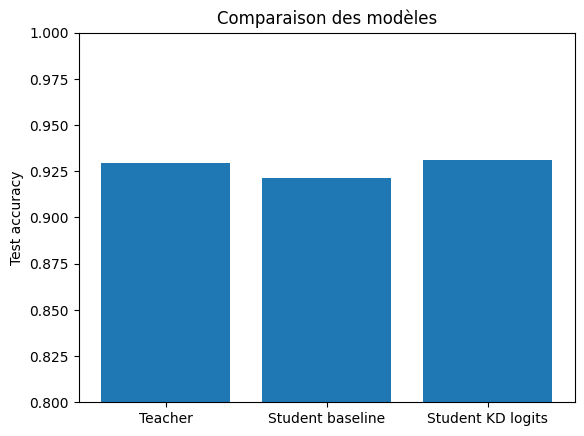

In [54]:
results = {
    "Teacher": teacher_test["acc"],
    "Student baseline": student_test["acc"],
    "Student KD logits": student_kd_test["acc"],
}

plt.figure()
plt.bar(results.keys(), results.values())
plt.ylabel("Test accuracy")
plt.title("Comparaison des modèles")
plt.ylim(0.8, 1.0)
plt.show()
